In [101]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd

from functools import partial
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve_fixed_load(L, a, b, metric):

    try: 
        warnings.simplefilter("error")
        if not check_feasibility(L, a, b):
            raise ValueError("infeasible")

        x = cp.Variable(len(a))

        if (metric == "sw") or (metric == 0):
            objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        elif (metric == "pf") or (metric == 1):
            objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
        elif (metric == "mm") or (metric == float("inf")):
            objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        else:
            y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
            objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))

        constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver="ECOS", abstol=1e-6)

        user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
        surplus = np.sum(user_surplus)

        return problem.value, x.value, user_surplus, surplus
    
    except (Warning, cp.SolverError, TypeError, ValueError) as e:
        return np.nan, np.full(len(a), np.nan), np.full(len(a), np.nan), np.nan
    

def solve(a, b, metric):
    pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
    results = pool.map(partial(solve_fixed_load, a=a, b=b, metric=metric), np.arange(0.001, 1.5, 0.001))
    results = [x for x in results if not np.isnan(x[0])]
    pool.close()
    return sorted(results, key=lambda x: -x[0])[0]

In [73]:
%%time

a = np.array([1, 2])
b = np.array([2, 3])

results = []
alpha_values = [0.0, 0.5, 1.0, 1.5, 3.0, float("inf")]
for alpha in tqdm.tqdm(alpha_values):
    val, sol, user_surplus, surplus = solve(a, b, alpha)
    results.append(dict(
        alpha=alpha,
        val=val, 
        sol0=sol[0],
        sol1=sol[1],
        sol=sol, 
        user_surplus0=user_surplus[0],
        user_surplus1=user_surplus[1],
        surplus=surplus
    ))
    
results = pd.DataFrame(results)    
results = results.sort_values("user_surplus0", ignore_index=True)    

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.02s/it]

CPU times: user 895 ms, sys: 9.14 s, total: 10 s
Wall time: 12.1 s


In [74]:
%%time

# get feasible region
x_grid = np.linspace(0, 2, 1001)
param_list = [(x0, x1, a, b) for x0 in x_grid for x1 in x_grid]

def is_feasible_wrapper(params):
    x0, x1, a, b = params
    L = x0 + x1
    s0 = -0.5*a[0]*x0**2 + (b[0] - L)*x0
    s1 = -0.5*a[1]*x1**2 + (b[1] - L)*x1
    is_feasible = (0 <= x0 <= 2*(b[0] - L)/a[0]) and (0 <= x1 <= 2*(b[1] - L)/a[1])
    is_feasible = is_feasible and (s0 >= 0) and (s1 >= 0)
    return dict(s0=s0, s1=s1, is_feasible=is_feasible)
    
pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
feasible_region = pool.map(is_feasible_wrapper, param_list)
feasible_region = pd.DataFrame(feasible_region).dropna()
feasible_region = feasible_region.loc[feasible_region.is_feasible, ["s0", "s1"]].reset_index(drop=True)
pool.close()

CPU times: user 4.06 s, sys: 1.85 s, total: 5.9 s
Wall time: 5.87 s


In [75]:
for alpha, sol0, sol1 in results[["alpha", "sol0", "sol1"]].values.round(3):
    print(f"{alpha:0.1f}  {sol0:0.3f}  {sol1:0.3f}  {sol0+sol1:0.3f}")

0.0  0.250  0.625  0.875
0.5  0.386  0.507  0.893
1.0  0.443  0.435  0.878
1.5  0.472  0.392  0.864
3.0  0.508  0.332  0.840
inf  0.547  0.260  0.807


In [76]:
for alpha, surplus0, surplus1 in results[["alpha", "user_surplus0", "user_surplus1"]].values.round(3):
    print(f"{alpha:0.1f}  {surplus0:0.3f}  {surplus1:0.3f}  {surplus0+surplus1:0.3f}")

0.0  0.250  0.937  1.187
0.5  0.353  0.811  1.164
1.0  0.399  0.734  1.133
1.5  0.425  0.683  1.108
3.0  0.460  0.607  1.067
inf  0.503  0.503  1.006


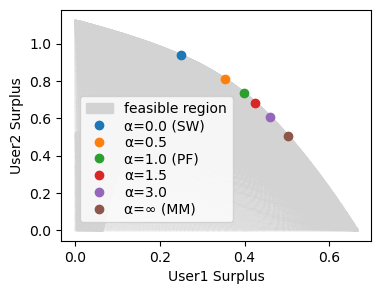

In [112]:
plt.figure(figsize=(4, 3))

plt.plot(feasible_region.s0, feasible_region.s1, ".", markersize=0.1, alpha=1, color="lightgray")
for alpha, user_surplus0, user_surplus1 in results[["alpha", "user_surplus0", "user_surplus1"]].values:
    plt.plot(user_surplus0, user_surplus1, ".", markersize=12)

plt.xlabel("User1 Surplus")
plt.ylabel("User2 Surplus")

plt.gca().legend(
    loc=4, bbox_to_anchor=(0.575, 0.05), labelspacing=0.2,
    handles=[
        mpatches.Patch(color=color, label=label) if color == "lightgray" 
        else mlines.Line2D([], [], color=color, linestyle='None', marker=".", markersize=12, label=label)
        for label, color in zip(
            ["feasible region", "α=0.0 (SW)", "α=0.5", "α=1.0 (PF)", "α=1.5", "α=3.0", "α=∞ (MM)"],
            ["lightgray", "C0", "C1", "C2", "C3", "C4", "C5"]
        )]
)

plt.show()

In [78]:
#  (SF)